# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

# Connect to database

In [2]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [15]:
query="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 64
"""

In [16]:
df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_125980\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38053 entries, 0 to 38052
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38053 non-null  datetime64[ns]
 1   net_load  38053 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.7 KB


In [18]:
df

,ts,net_load
0,2019-03-01 00:00:00,10.680
1,2019-03-01 00:15:00,7.320
2,2019-03-01 00:30:00,7.410
3,2019-03-01 00:45:00,7.630
4,2019-03-01 01:00:00,8.140
...,...,...
38048,2020-03-31 22:45:00,7.510
38049,2020-03-31 23:00:00,7.370
38050,2020-03-31 23:15:00,7.570
38051,2020-03-31 23:30:00,6.810


In [19]:
# Convert 'ts' to datetime and set as index
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

df

,net_load
ts,
2019-03-01 00:00:00,10.680
2019-03-01 00:15:00,7.320
2019-03-01 00:30:00,7.410
2019-03-01 00:45:00,7.630
2019-03-01 01:00:00,8.140
...,...
2020-03-31 22:45:00,7.510
2020-03-31 23:00:00,7.370
2020-03-31 23:15:00,7.570


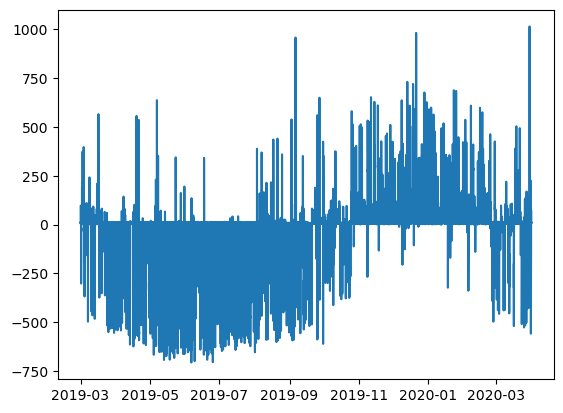

In [20]:
plt.plot(df.index, df.net_load)
plt.show()

# Normalise net load (as seen in literature)

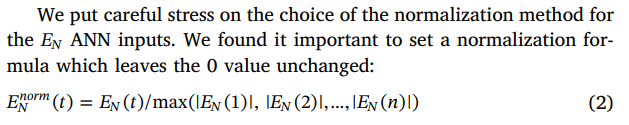



High-resolution net load forecasting for micro-neighbourhoods with high
penetration of renewable energy sources
P. Kobylinskia
, M. Wierzbowskia
, K. Piotrowskib,

In [21]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

df

,net_load,net_load_norm
ts,,
2019-03-01 00:00:00,10.680,0.010541
2019-03-01 00:15:00,7.320,0.007225
2019-03-01 00:30:00,7.410,0.007313
2019-03-01 00:45:00,7.630,0.007531
2019-03-01 01:00:00,8.140,0.008034
...,...,...
2020-03-31 22:45:00,7.510,0.007412
2020-03-31 23:00:00,7.370,0.007274
2020-03-31 23:15:00,7.570,0.007471


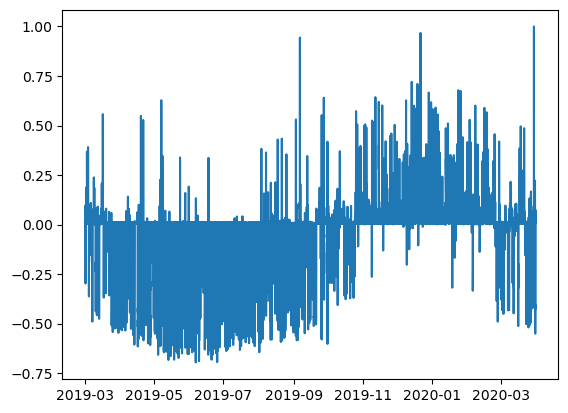

In [22]:
plt.plot(df.index, df.net_load_norm)
plt.show()

# Prepare data set for LSTM

In [23]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Given the array X: 
 [ 0.01054086  0.00722463  0.00731346  0.0075306   0.00803395  0.00829056
  0.00729372  0.0078563   0.00978089  0.00803395  0.00838926  0.0092578
  0.00772799  0.00732333  0.0072345   0.00828069  0.00751086  0.00736281
  0.00749112  0.00763916  0.00742203  0.00712594  0.00738255  0.00737268
  0.00773786  0.02903672  0.09586459  0.06607777  0.04893407  0.01456771
  0.0150908   0.00737268  0.00659297  0.00113502  0.00633636  0.0064548
  0.00549743  0.00642519  0.00740229  0.00513225  0.00565535  0.00524082
  0.0064548   0.00650415  0.00694828  0.00835965  0.00681998  0.00621792
  0.00751086  0.00644493 -0.1451441  -0.29764114 -0.16143901 -0.16126135
 -0.09823332 -0.07680616 -0.08920253 -0.03861034 -0.01698579 -0.03391236
  0.0035531  -0.00189499  0.00521121  0.00817213  0.00751086  0.00691867
  0.00882353  0.00709633  0.00648441  0.00694828  0.0071062   0.00739242
  0.00588235  0.0073332   0.00724437  0.01286024  0.00228977  0.01068891
  0.00500395  0.0072345   0.0067

# Split into train, test, val (train = 40 weeks, test = 1 day, val = 1 day)

In [24]:
def split_time_series(X, y, train_size, test_size, val_size, interval, ts):

    train_end = train_size * interval
    test_end = train_end + test_size * interval

    X_train, y_train, ts_train = X[:train_end], y[:train_end], ts[:train_end]
    X_test, y_test, ts_test = X[train_end:test_end], y[train_end:test_end], ts[train_end:test_end]
    X_val, y_val, ts_val = X[test_end:test_end+val_size*interval], y[test_end:test_end+val_size*interval], ts[test_end:test_end+val_size*interval]

    return X_train, y_train, ts_train,  X_test, y_test, ts_test, X_val, y_val, ts_val

interval = 96  # no. of 15-min increments in 1 day

# Use the function to split your dataset
X_train, y_train, ts_train, X_test, y_test, ts_test, X_val, y_val, ts_val = split_time_series(
    X, y,
    train_size=40*7,  # 40 weeks
    test_size=1,     # 1 day
    val_size=1,      # 1 day
    interval=interval,
    ts = ts
)

X_train.shape, y_train.shape, ts_train.shape, X_test.shape, y_test.shape, ts_test.shape, X_val.shape, y_val.shape, ts_val.shape

((26880, 96, 1),
 (26880,),
 (26880,),
 (96, 96, 1),
 (96,),
 (96,),
 (96, 96, 1),
 (96,),
 (96,))

# Build LSTM model

In [25]:
model1 = Sequential()
model1.add(InputLayer((window_size, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
cp1 = ModelCheckpoint('model6.keras', save_best_only=True)
model1.compile(loss='mae', optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

# Fit LSTM model

In [27]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.0430 - mean_absolute_error: 0.0430 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0246 - mean_absolute_error: 0.0246 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0233 - mean_absolute_error: 0.0233 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0267 - val_mean_absolute_error: 0.0267
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0196 - mean_absolute_error: 0.0196 - val_loss: 0.0256 - val_mean_absolute_error: 0.0256
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0195 - mean_absolute_err

# Check training results

In [28]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

train_results

840/840 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


,Train Predictions,Actuals
0,0.007666,0.008379
1,0.008630,0.007442
2,0.007842,0.007669
3,0.007997,0.007373
4,0.007745,0.008557
...,...,...
26875,0.014137,0.015338
26876,0.014070,0.019947
26877,0.017850,0.039281
26878,0.034518,0.039272


Training MAE: 0.018391506616774217


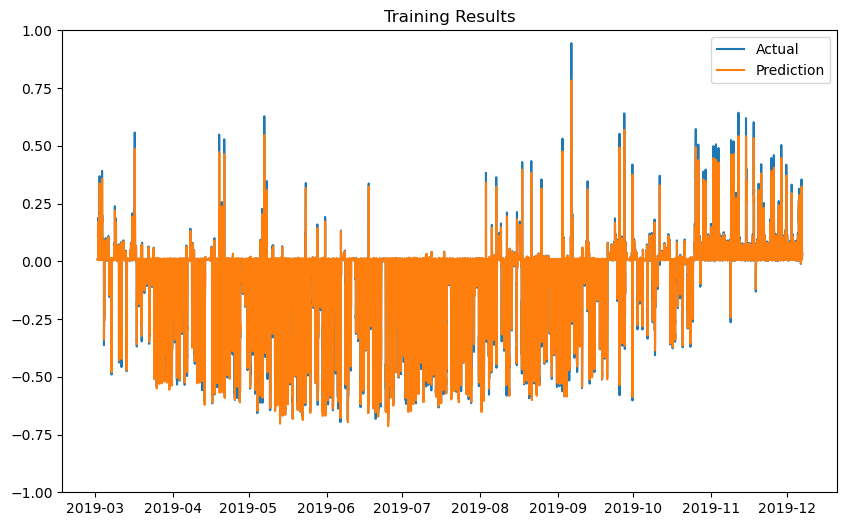

In [29]:
plt.figure(figsize=(10,6))
plt.title("Training Results")
plt.plot(ts_train, train_results['Actuals'], label='Actual')
plt.plot(ts_train, train_results['Train Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_train, train_predictions)}")

# Check validation results

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Validation Results")
plt.plot(ts_val, val_results['Actuals'], label='Actual')
plt.plot(ts_val, val_results['Val Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_val, val_predictions)}")

# Check test results

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Testing Results")
plt.plot(ts_test, test_results['Actuals'], label='Actual')
plt.plot(ts_test, test_results['Test Predictions'], label='Prediction')
plt.ylim([-1,1])
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_test, test_predictions)}")